## Lab  02: GPR and FDEM
#### Lillian Hanson, 02/12/2026

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np

## EM31 Data

In [2]:
# Parse raw EM-31 file -----------------------------
def parse_raw_em31(file_name):
    records = []

    with open(file_name, 'r', errors='ignore') as f:
        for line in f:
            line = line.strip()
            if not line.startswith('T'):
                continue

            # Signed 4-digit channels
            channels = re.findall(r'[+-]\d{4}', line)
            # First integer after channels = time counter
            times = re.findall(r'\s(\d+)', line)

            if len(channels) >= 2 and len(times) >= 1:
                records.append([
                    int(times[0]),
                    int(channels[0]),
                    int(channels[1])
                ])

    df = pd.DataFrame(records, columns=['Time', 'Channel1', 'Channel2'])
    return df


# Clean + distance conversion -----------------------------

def clean_em31_data(df, meters_per_sample=0.1, trim_meters=2.0, mirror=True):
    df = df.copy()

    # Sort just in case
    df = df.sort_values('Time').reset_index(drop=True)

    # Convert to distance along line
    df['Distance_m'] = np.arange(len(df)) * meters_per_sample

    # Trim beginning & end
    max_dist = df['Distance_m'].iloc[-1]
    df = df[
        (df['Distance_m'] >= trim_meters) &
        (df['Distance_m'] <= max_dist - trim_meters)
    ]

    # Mirror over x-axis (invert signal)
    if mirror:
        df[['Channel1', 'Channel2']] *= -1

    return df.reset_index(drop=True)

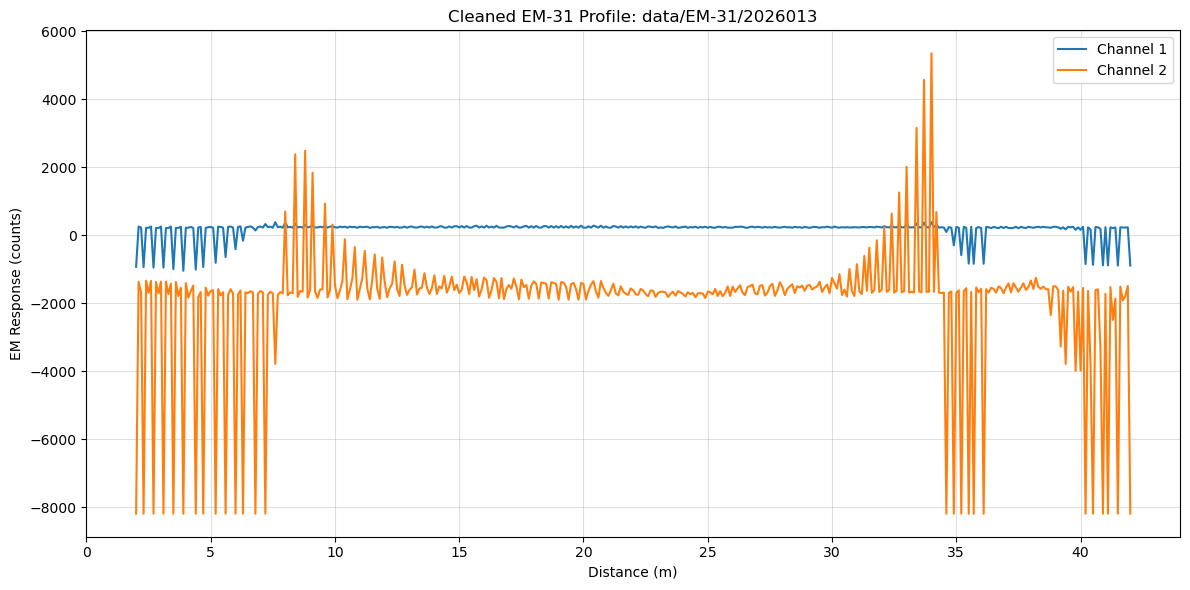

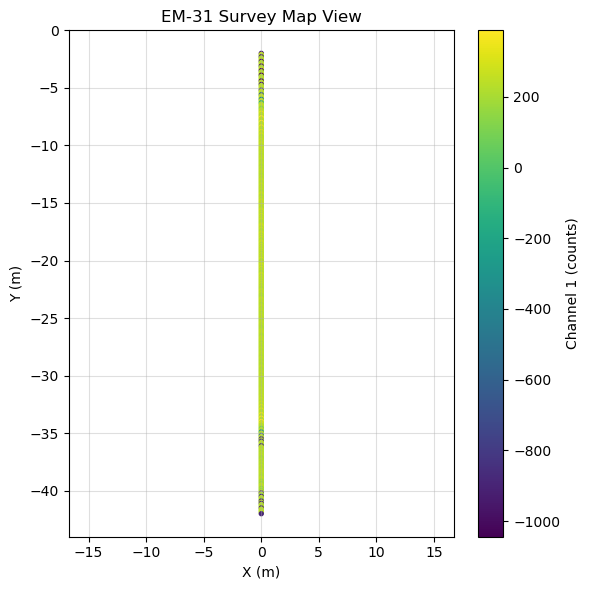

In [9]:
# Plot cleaned profiles ----------------------------- 
def plot_profiles(df, title):
    plt.figure(figsize=(12, 6))

    plt.plot(df['Distance_m'], df['Channel1'], label='Channel 1')
    plt.plot(df['Distance_m'], df['Channel2'], label='Channel 2')

    plt.xlabel('Distance (m)')
    plt.ylabel('EM Response (counts)')
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.4)
    plt.tight_layout()
    plt.show()


# Simple survey map (line) ----------------------------- 

def plot_map(df, azimuth_deg=270): # azimuth_deg = direction of walk, west
    theta = np.deg2rad(azimuth_deg)

    df['X'] = df['Distance_m'] * np.cos(theta)
    df['Y'] = df['Distance_m'] * np.sin(theta)

    plt.figure(figsize=(6, 6))
    plt.scatter(df['X'], df['Y'], c=df['Channel1'], s=8)
    plt.colorbar(label='Channel 1 (counts)')
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title('EM-31 Survey Map View')
    plt.axis('equal')
    plt.grid(alpha=0.4)
    plt.tight_layout()
    plt.show()


# ----------------------------- Run everything
file_to_plot = "data/EM-31/2026013"

raw_df = parse_raw_em31(file_to_plot)

clean_df = clean_em31_data(
    raw_df,
    meters_per_sample=0.1,   # <-- adjust if needed
    trim_meters=2.0,
    mirror=True
)

plot_profiles(clean_df, f"Cleaned EM-31 Profile: {file_to_plot}")
plot_map(clean_df, azimuth_deg=270)  # example: walking west

The areas with higher amplitude here likely indicate higher conductivity, which is probably our target.

## Gem2 Data

In [4]:
gem2_file = 'data/GEM2/orient1/01-xg-03oc-114_gem.csv'
df = pd.read_csv(gem2_file)

# Compute stepwise distance
dx = np.diff(df['X'], prepend=df['X'].iloc[0])
dy = np.diff(df['Y'], prepend=df['Y'].iloc[0])
df['distance'] = np.cumsum(np.sqrt(dx**2 + dy**2))

midpoint = 0.5 * (df['distance'].min() + df['distance'].max())

trim_dist = 4  # meters
dmin = df['distance'].min() + trim_dist
dmax = df['distance'].max() - trim_dist

df = df[(df['distance'] >= dmin) & (df['distance'] <= dmax)].reset_index(drop=True)

# Fold distance about midpoint
df['folded_dist'] = np.abs(df['distance'] - midpoint)



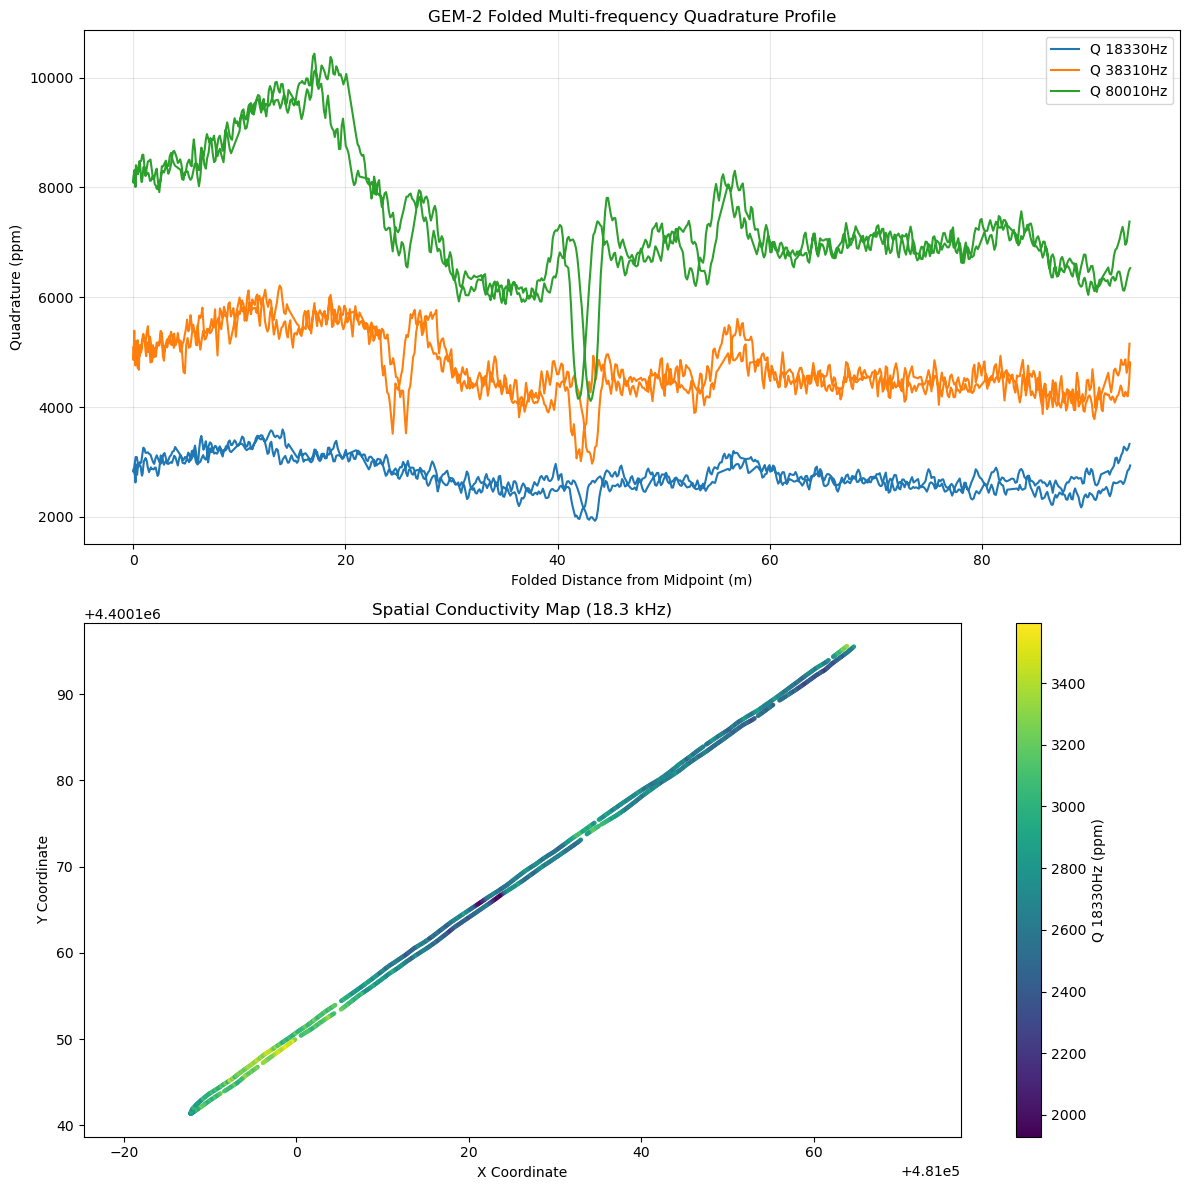

In [5]:
frequencies = ['18330Hz', '38310Hz', '80010Hz']

plt.figure(figsize=(12, 12))

# Folded profile
plt.subplot(2, 1, 1)
for freq in frequencies:
    col = f'Q_{freq}'
    plt.plot(df['folded_dist'], df[col], label=f'Q {freq}')

plt.title('GEM-2 Folded Multi-frequency Quadrature Profile')
plt.xlabel('Folded Distance from Midpoint (m)')
plt.ylabel('Quadrature (ppm)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
sc = plt.scatter(df['X'], df['Y'], c=df['Q_18330Hz'], cmap='viridis', s=5)
plt.colorbar(sc, label='Q 18330Hz (ppm)')
plt.title('Spatial Conductivity Map (18.3 kHz)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.axis('equal')

plt.tight_layout()
plt.show()

These results are consistent with the EM31 profiles. These results could also be compared with our TDEM inversions to ensure consistency. The TDEM inversion typically captures more depth than the FDEM of the GEM-2.

## GPR Data

**100 mHz GPR Data Profile**
![100 mHz data visualization](data/GPR/lab02gpr100mhz.png)

**250 mHz GPR Data Profile**
![100 mHz data visualization](data/GPR/lab02gpr250mhz.png)

The 100 mHz profile shows only noise; it may need further processing, or could indicate user error in the data collection itself. The 250 mHz profile shows an anomaly in the center of the profile which is likely our target. This location is where we expected the target to be, and it also aligns with target locations found with the EM31 and Gem-2. 

## Lab Notebook Pages

![Lab Notebook Page](lab02_notebookpages_page-0001.jpg)